# 0. Importing the Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from collections import deque
from datetime import timedelta

# 1. Downloading the Datasets

In [2]:
product_catalog = pd.read_csv("original_data/product_catalog.csv")
product_category = pd.read_csv("original_data/product_category_map.csv")
transactions = pd.read_csv("original_data/transactions.csv")
test = pd.read_csv("original_data/test.csv")

## 1a. Analyzing & Preprocessing the Dataset

Investigating the entities, dtypes, numeric information etc.

### <center> - Transactions - </center>

In [3]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
0,38769,3477,2020-06-01,1
1,42535,30474,2020-06-01,1
2,42535,15833,2020-06-01,1
3,42535,20131,2020-06-01,1
4,42535,4325,2020-06-01,1


In [4]:
# Filter out rows in transactions where customer_id is not in test
transactions = transactions[transactions['customer_id'].isin(test['customer_id'])].reset_index(drop=True)

transactions.head()

,customer_id,product_id,purchase_date,quantity
0,44176,20159,2020-06-01,1
1,39433,197,2020-06-01,1
2,39433,29370,2020-06-01,1
3,3172,9649,2020-06-01,1
4,13085,1509,2020-06-01,1


In [5]:
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])

In [6]:
transactions

,customer_id,product_id,purchase_date,quantity
0,44176,20159,2020-06-01,1
1,39433,197,2020-06-01,1
2,39433,29370,2020-06-01,1
3,3172,9649,2020-06-01,1
4,13085,1509,2020-06-01,1
...,...,...,...,...
273788,36347,17658,2021-01-31,2
273789,17894,21280,2021-01-31,3
273790,17894,31268,2021-01-31,1
273791,10900,18270,2021-01-31,1


In [7]:
transactions.describe()

,customer_id,product_id,purchase_date,quantity
count,273793.000000,273793.000000,273793,273793.000000
mean,23084.185122,16487.366960,2020-10-04 14:57:28.646240256,1.399251
min,0.000000,1.000000,2020-06-01 00:00:00,1.000000
25%,11757.000000,8343.000000,2020-08-04 00:00:00,1.000000
50%,23095.000000,16879.000000,2020-10-05 00:00:00,1.000000
75%,34720.000000,24528.000000,2020-12-06 00:00:00,1.000000
max,46130.000000,32775.000000,2021-01-31 00:00:00,100.000000
std,13245.821228,9433.718025,NaN,1.457499


In [8]:
transactions.isna().sum()

customer_id      0
product_id       0
purchase_date    0
quantity         0
dtype: int64

In [9]:
transactions.dtypes

customer_id               int64
product_id                int64
purchase_date    datetime64[ns]
quantity                  int64
dtype: object

In [10]:
transactions.nunique()

customer_id       7251
product_id       20623
purchase_date      245
quantity            32
dtype: int64

In [11]:
# Sort by customer_id, product_id, and purchase_date
transactions = transactions.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

In [12]:
transactions.head()

,customer_id,product_id,purchase_date,quantity
99920,0,1505,2020-09-01,1
211259,0,6446,2020-12-11,1
251491,0,6446,2021-01-15,1
183150,0,9325,2020-11-20,1
67740,0,12468,2020-08-03,1


In [13]:
unique_customers = transactions['customer_id'].nunique()
print("Number of unique customers:", unique_customers)

Number of unique customers: 7251


In [14]:
clustered_products = pd.read_csv("updated_product_catalog.csv")
clustered_products.head()
clustered_products

,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,categories_length,parent_categories,combined_categories,combined_cluster,cluster
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]",4,"[2832, 1178, 3898, 3898]","[3908, 3909, 2890, 2832, 855, 1178, 3898]",0,0
1,28640,1366,10,1,537,0,101,[],0,[],[],-1,1541
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3...",13,"[1420, 3860, 600, 600, 3241, 3241, 3241, 600, ...","[163, 3270, 3912, 3561, 3913, 3595, 12, 3914, ...",1,1
3,21399,1090,10,1,511,0,0,[3270],1,[1420],"[1420, 3270]",2,2
4,8504,768,4,1,484,0,66,[2470],1,[2566],"[2470, 2566]",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32771,12036,1383,10,0,503,0,101,"[3502, 1088, 2004, 691, 3422, 2308, 308, 3688,...",11,"[3860, 458, 458, 458, 458, 322, 600, 600, 600,...","[1088, 322, 2308, 3688, 3241, 458, 12, 3502, 6...",5946,5946
32772,22709,567,4,2,491,3,66,"[3900, 3905, 3903, 3910, 1807, 274, 1467, 914]",8,"[3898, 3898, 3898, 3898, 1072, 2920, 2475, 3565]","[3905, 3910, 2920, 2475, 3565, 1807, 1072, 274...",8054,8054
32773,32322,1385,10,1,500,0,37,"[2686, 2609, 725]",3,"[2917, 1175, 725, 1735]","[2917, 1735, 2609, 725, 1175, 2686]",617,617
32774,19118,1113,6,2,491,0,117,"[3900, 3910, 3903, 2473, 914, 274]",6,"[3898, 3898, 3898, 2566, 3565, 2920]","[3910, 2566, 2920, 2473, 3565, 914, 274, 3898,...",64,64


In [15]:
merged_df = transactions.merge(clustered_products[['product_id', 'cluster']], on='product_id', how='left')

# Dropping the original product_id column and renaming cluster as cluster_id
merged_df = merged_df.rename(columns={'cluster': 'cluster_id'})

merged_df

,customer_id,product_id,purchase_date,quantity,cluster_id
0,0,1505,2020-09-01,1,1304
1,0,6446,2020-12-11,1,105
2,0,6446,2021-01-15,1,105
3,0,9325,2020-11-20,1,7816
4,0,12468,2020-08-03,1,278
...,...,...,...,...,...
273788,46130,29288,2020-11-28,1,2340
273789,46130,29499,2020-11-28,1,2971
273790,46130,29995,2020-12-10,1,2068
273791,46130,30712,2020-08-19,1,7636


In [16]:
# Sort by customer_id, product_id, and purchase_date
merged_df = merged_df.sort_values(by=['customer_id', 'cluster_id', 'purchase_date'])

In [17]:
merged_df.drop(columns=['product_id'], inplace=True)

In [18]:
merged_df['next_purchase_date'] = merged_df.groupby(['customer_id', 'cluster_id'])['purchase_date'].shift(-1)
# merged_df['next_purchase_date'] = merged_df.groupby(['customer_id', 'product_id'])['purchase_date'].shift(-1)
merged_df

,customer_id,purchase_date,quantity,cluster_id,next_purchase_date
12,0,2020-11-20,1,55,2020-12-11
13,0,2020-12-11,1,55,2021-01-25
14,0,2021-01-25,2,55,NaT
11,0,2020-10-09,1,105,2020-12-11
1,0,2020-12-11,1,105,2021-01-15
...,...,...,...,...,...
273791,46130,2020-08-19,1,7636,2020-12-10
273792,46130,2020-12-10,1,7636,NaT
273754,46130,2020-06-03,1,7661,2020-11-09
273755,46130,2020-11-09,2,7661,2020-12-20


In [19]:
merged_df['re_purchased_day'] = (((merged_df['next_purchase_date'] - merged_df['purchase_date']).dt.days) / merged_df['quantity']).fillna(0).astype(int)
merged_df.head()

,customer_id,purchase_date,quantity,cluster_id,next_purchase_date,re_purchased_day
12,0,2020-11-20,1,55,2020-12-11,21
13,0,2020-12-11,1,55,2021-01-25,45
14,0,2021-01-25,2,55,NaT,0
11,0,2020-10-09,1,105,2020-12-11,63
1,0,2020-12-11,1,105,2021-01-15,35


In [20]:
max_purchase_date = merged_df['purchase_date'].max()

# Calculating the cutoff date (4 weeks before max_purchase_date) to drop
cutoff_date = max_purchase_date - timedelta(weeks=3)

# Filter the last row of each customer-product pair
filtered_transactions = merged_df.sort_values(by=['customer_id', 'cluster_id', 'purchase_date'])
last_rows = filtered_transactions.drop_duplicates(subset=['customer_id', 'cluster_id'], keep='last')
filtered_transactions = filtered_transactions[~filtered_transactions.index.isin(last_rows.index)]

filtered_transactions

,customer_id,purchase_date,quantity,cluster_id,next_purchase_date,re_purchased_day
12,0,2020-11-20,1,55,2020-12-11,21
13,0,2020-12-11,1,55,2021-01-25,45
11,0,2020-10-09,1,105,2020-12-11,63
1,0,2020-12-11,1,105,2021-01-15,35
8,0,2020-06-05,1,400,2020-10-09,126
...,...,...,...,...,...,...
273780,46130,2020-10-23,1,4178,2021-01-27,96
273778,46130,2020-11-09,5,6538,2020-12-20,8
273791,46130,2020-08-19,1,7636,2020-12-10,113
273754,46130,2020-06-03,1,7661,2020-11-09,159


In [21]:
new_df = filtered_transactions.drop(columns=['purchase_date', 'next_purchase_date'])
new_df.head()

,customer_id,quantity,cluster_id,re_purchased_day
12,0,1,55,21
13,0,1,55,45
11,0,1,105,63
1,0,1,105,35
8,0,1,400,126


In [22]:
new_df[new_df["quantity"] == 1].re_purchased_day.unique()

array([ 21,  45,  63,  35, 126,  68,  37,  28,   0,  78,  55, 111, 146,
       201, 203,  40,  81,  27,  19,  98, 159,  52,  30,  62,  74,  16,
       104,  84,  33,  31,  20, 164,  26, 120,  49,  82,  44, 130,  25,
        51, 118, 124,  87,  77,   9,  46, 169,  12, 176, 155, 133,  66,
        70,  85,  39, 137,  56,  36, 110,  23,  29, 149, 131,  72,  89,
        50,   5,  76,  80, 123,  90, 210, 112,  42,  53,  48,  64, 154,
        22,  69,  34, 135, 173,  14, 167,  54,  32,  59,   8,  11,  60,
        17, 178,  10,  95,  94,  86, 138,  97, 218, 119,  24,  93,  79,
       129,  65,  67, 139,  43,   4,  47,  96, 177, 190,   1, 106,  71,
       152, 143,  83,  18,  13,  91,  73, 142, 117,   6,  88, 113,  99,
       185, 116,  57, 171,  75, 114, 100, 109, 127,   7, 107, 156, 105,
       122, 121, 202,  92, 132, 162, 182,  58,  38, 101, 157, 140, 148,
       192, 102, 186, 134, 141, 115,  15, 197,  61, 205, 213, 160, 211,
       147,  41, 200, 136, 179, 238, 103, 175, 195, 212, 236, 18

In [23]:
# Counting the occurrences of each re_purchased_week value
counts = new_df['re_purchased_day'].value_counts()

# Creating a new DataFrame to include weeks from 0 to 5
re_purchased_df = pd.DataFrame({'re_purchased_day': range(6), 'count': 0})
re_purchased_df.set_index('re_purchased_day', inplace=True)

# Updating the counts for weeks that exist in the data
for week, count in counts.items():
    week = 1 + (week // 7)
    if week in re_purchased_df.index:
        re_purchased_df.at[week, 'count'] = count

    elif week > 5:
        re_purchased_df.at[5, 'count'] += count

# Calculating the percentages
total_counts = re_purchased_df['count'].sum()
re_purchased_df['percentage'] = (re_purchased_df['count'] / total_counts * 100).round(2)

# Resetting index to make it more readable
final_df = re_purchased_df.reset_index()
final_df


,re_purchased_day,count,percentage
0,0,0,0.00
1,1,464,1.00
2,2,875,1.88
3,3,923,1.99
4,4,874,1.88
5,5,43316,93.25


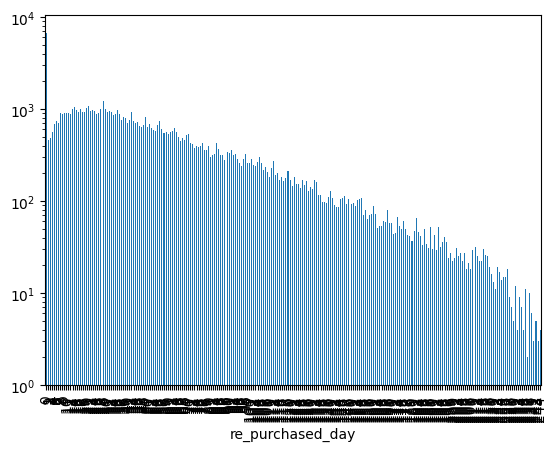

In [24]:
new_df["re_purchased_day"].value_counts().sort_index().plot(kind="bar", log=True);

In [25]:
final_df.describe()

,re_purchased_day,count,percentage
count,6.000000,6.000000,6.000000
mean,2.500000,7742.000000,16.666667
std,1.870829,17431.243203,37.525790
min,0.000000,0.000000,0.000000
25%,1.250000,566.500000,1.220000
50%,2.500000,874.500000,1.880000
75%,3.750000,911.000000,1.962500
max,5.000000,43316.000000,93.250000


# <center> Merging the Datasets </center>

In [26]:
new_df

,customer_id,quantity,cluster_id,re_purchased_day
12,0,1,55,21
13,0,1,55,45
11,0,1,105,63
1,0,1,105,35
8,0,1,400,126
...,...,...,...,...
273780,46130,1,4178,96
273778,46130,5,6538,8
273791,46130,1,7636,113
273754,46130,1,7661,159


In [27]:
average_repurchased_day = new_df.groupby(['customer_id', 'cluster_id'])['re_purchased_day'].transform('mean')

# Adding a new column for average_repurchased_day
new_df['average_repurchased_day'] = average_repurchased_day

new_df

,customer_id,quantity,cluster_id,re_purchased_day,average_repurchased_day
12,0,1,55,21,33.0
13,0,1,55,45,33.0
11,0,1,105,63,49.0
1,0,1,105,35,49.0
8,0,1,400,126,94.5
...,...,...,...,...,...
273780,46130,1,4178,96,96.0
273778,46130,5,6538,8,8.0
273791,46130,1,7636,113,113.0
273754,46130,1,7661,159,89.5


In [28]:
new_df['total_transactions'] = new_df.groupby('customer_id')['customer_id'].transform('count')
new_df

,customer_id,quantity,cluster_id,re_purchased_day,average_repurchased_day,total_transactions
12,0,1,55,21,33.0,6
13,0,1,55,45,33.0,6
11,0,1,105,63,49.0,6
1,0,1,105,35,49.0,6
8,0,1,400,126,94.5,6
...,...,...,...,...,...,...
273780,46130,1,4178,96,96.0,12
273778,46130,5,6538,8,8.0,12
273791,46130,1,7636,113,113.0,12
273754,46130,1,7661,159,89.5,12


In [29]:
new_df['average_unit_per_transaction'] = new_df.groupby('customer_id')['quantity'].transform('mean')
new_df

,customer_id,quantity,cluster_id,re_purchased_day,average_repurchased_day,total_transactions,average_unit_per_transaction
12,0,1,55,21,33.0,6,1.0
13,0,1,55,45,33.0,6,1.0
11,0,1,105,63,49.0,6,1.0
1,0,1,105,35,49.0,6,1.0
8,0,1,400,126,94.5,6,1.0
...,...,...,...,...,...,...,...
273780,46130,1,4178,96,96.0,12,1.5
273778,46130,5,6538,8,8.0,12,1.5
273791,46130,1,7636,113,113.0,12,1.5
273754,46130,1,7661,159,89.5,12,1.5


In [30]:
cluster_means = pd.read_csv("cluster_means.csv")

In [31]:
# Merge new_df with cluster_means on the cluster_id column
new_df = new_df.merge(cluster_means, on='cluster_id', how='left')

# Display the updated new_df
new_df.head()

,customer_id,quantity,cluster_id,re_purchased_day,average_repurchased_day,total_transactions,average_unit_per_transaction,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5
0,0,1,55,21,33.0,6,1.0,4.210526,0.789474,434.868421,0.763158,69.868421
1,0,1,55,45,33.0,6,1.0,4.210526,0.789474,434.868421,0.763158,69.868421
2,0,1,105,63,49.0,6,1.0,4.562500,0.375000,26.687500,1.406250,113.937500
3,0,1,105,35,49.0,6,1.0,4.562500,0.375000,26.687500,1.406250,113.937500
4,0,1,400,126,94.5,6,1.0,5.000000,0.722222,365.222222,0.666667,118.777778


In [32]:
new_df.to_csv("new_df.csv", index=False)

In [33]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, accuracy_score

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, callback

# Assuming `new_df` is the dataframe loaded already
# Drop ID columns and target variable
X = new_df.drop(columns=['customer_id', 'cluster_id', 're_purchased_day', 'quantity'])
y = new_df['re_purchased_day']

# Split the data into training and testing sets
percent = 0.95
X_train, X_test, y_train, y_test = X[:int(percent*len(X))], X[int(percent*len(X)):], y[:int(percent*len(y))], y[int(percent*len(y)):]

# Train an XGBoost Regressor
model = XGBRegressor(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

[0]	validation_0-rmse:44.84656
[1]	validation_0-rmse:41.26146
[2]	validation_0-rmse:38.11754
[3]	validation_0-rmse:35.35213
[4]	validation_0-rmse:32.94959
[5]	validation_0-rmse:32.82778
[6]	validation_0-rmse:30.76367
[7]	validation_0-rmse:28.97903
[8]	validation_0-rmse:27.44093
[9]	validation_0-rmse:27.40137
[10]	validation_0-rmse:27.34572
[11]	validation_0-rmse:26.05930
[12]	validation_0-rmse:24.96456
[13]	validation_0-rmse:24.03919
[14]	validation_0-rmse:23.25928
[15]	validation_0-rmse:22.60795
[16]	validation_0-rmse:22.06029
[17]	validation_0-rmse:21.60866
[18]	validation_0-rmse:21.23090
[19]	validation_0-rmse:20.92249
Mean Squared Error (MSE): 437.75042724609375
R² Score: 0.7849380373954773


In [35]:
# Load the test data
test_data = pd.read_csv("original_data/test.csv")

# Add the cluster_id column for the corresponding products in the row
test_data = test_data.merge(clustered_products[['product_id', 'cluster']], on='product_id', how='left')
test_data = test_data.rename(columns={'cluster': 'cluster_id'})

display(test_data)

,id,customer_id,product_id,prediction,cluster_id
0,0,0,20664,NaN,400
1,1,0,28231,NaN,55
2,2,13,2690,NaN,493
3,3,15,1299,NaN,64
4,4,15,20968,NaN,3824
...,...,...,...,...,...
9995,9995,46118,20106,NaN,163
9996,9996,46124,19677,NaN,5257
9997,9997,46125,12878,NaN,682
9998,9998,46127,7963,NaN,951


In [36]:

# Add average_repurchased_week for the same customer - cluster pair
test_data = test_data.merge(new_df[['customer_id', 'cluster_id', 'average_repurchased_day']], on=['customer_id', 'cluster_id'], how='left')

test_data.drop_duplicates(subset=['customer_id', 'product_id'], keep='first', inplace=True)

display(test_data)

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day
0,0,0,20664,NaN,400,94.500000
2,1,0,28231,NaN,55,33.000000
4,2,13,2690,NaN,493,67.000000
7,3,15,1299,NaN,64,42.333333
10,4,15,20968,NaN,3824,36.333333
...,...,...,...,...,...,...
24592,9995,46118,20106,NaN,163,42.250000
24596,9996,46124,19677,NaN,5257,33.600000
24601,9997,46125,12878,NaN,682,120.500000
24603,9998,46127,7963,NaN,951,25.250000


In [37]:

# Add total_transactions corresponding to customer_id
test_data = test_data.merge(new_df[['customer_id', 'total_transactions']], on='customer_id', how='left')

test_data.drop_duplicates(subset=['customer_id', 'product_id'], keep='first', inplace=True)

display(test_data)

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions
0,0,0,20664,NaN,400,94.500000,6
6,1,0,28231,NaN,55,33.000000,6
12,2,13,2690,NaN,493,67.000000,17
29,3,15,1299,NaN,64,42.333333,13
42,4,15,20968,NaN,3824,36.333333,13
...,...,...,...,...,...,...,...
139322,9995,46118,20106,NaN,163,42.250000,15
139337,9996,46124,19677,NaN,5257,33.600000,18
139355,9997,46125,12878,NaN,682,120.500000,3
139358,9998,46127,7963,NaN,951,25.250000,6


In [38]:

# # Add average_unit_per_transaction corresponding to customer_id
test_data = test_data.merge(new_df[['customer_id', 'average_unit_per_transaction']], on='customer_id', how='left')

test_data.drop_duplicates(subset=['customer_id', 'product_id'], keep='first', inplace=True)

display(test_data)

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions,average_unit_per_transaction
0,0,0,20664,NaN,400,94.500000,6,1.000000
6,1,0,28231,NaN,55,33.000000,6,1.000000
12,2,13,2690,NaN,493,67.000000,17,1.176471
29,3,15,1299,NaN,64,42.333333,13,1.307692
42,4,15,20968,NaN,3824,36.333333,13,1.307692
...,...,...,...,...,...,...,...,...
139322,9995,46118,20106,NaN,163,42.250000,15,1.400000
139337,9996,46124,19677,NaN,5257,33.600000,18,1.000000
139355,9997,46125,12878,NaN,682,120.500000,3,1.000000
139358,9998,46127,7963,NaN,951,25.250000,6,1.500000


In [39]:
# Merge new_df with cluster_means on the cluster_id column
test_data = test_data.merge(cluster_means, on='cluster_id', how='left')

display(test_data)

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions,average_unit_per_transaction,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5
0,0,0,20664,NaN,400,94.500000,6,1.000000,5.000000,0.722222,365.222222,0.666667,118.777778
1,1,0,28231,NaN,55,33.000000,6,1.000000,4.210526,0.789474,434.868421,0.763158,69.868421
2,2,13,2690,NaN,493,67.000000,17,1.176471,9.023622,0.779528,477.299213,0.921260,54.740157
3,3,15,1299,NaN,64,42.333333,13,1.307692,6.526506,0.663855,481.528916,1.156627,89.350602
4,4,15,20968,NaN,3824,36.333333,13,1.307692,4.000000,0.000000,444.000000,0.000000,144.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,46118,20106,NaN,163,42.250000,15,1.400000,4.000000,0.500000,491.000000,0.000000,66.000000
9996,9996,46124,19677,NaN,5257,33.600000,18,1.000000,4.000000,0.500000,491.000000,3.000000,89.333333
9997,9997,46125,12878,NaN,682,120.500000,3,1.000000,4.000000,0.400000,451.800000,0.000000,81.600000
9998,9998,46127,7963,NaN,951,25.250000,6,1.500000,5.959184,0.816327,401.734694,0.918367,80.795918


In [40]:
# Prepare the test features
X_test = test_data.drop(columns=['id', 'customer_id', 'product_id', 'prediction', 'cluster_id'])

# Make predictions on the test data
test_predictions = model.predict(X_test)

# Add predictions to the test data
test_data['prediction'] = test_predictions

# Save the test data with predictions to a new CSV file
test_data.to_csv("test_with_predictions.csv", index=False)

# Display the first few rows of the test data with predictions
test_data.head()

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions,average_unit_per_transaction,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5
0,0,0,20664,88.052856,400,94.500000,6,1.000000,5.000000,0.722222,365.222222,0.666667,118.777778
1,1,0,28231,39.266312,55,33.000000,6,1.000000,4.210526,0.789474,434.868421,0.763158,69.868421
2,2,13,2690,63.502056,493,67.000000,17,1.176471,9.023622,0.779528,477.299213,0.921260,54.740157
3,3,15,1299,43.588779,64,42.333333,13,1.307692,6.526506,0.663855,481.528916,1.156627,89.350602
4,4,15,20968,39.564148,3824,36.333333,13,1.307692,4.000000,0.000000,444.000000,0.000000,144.000000


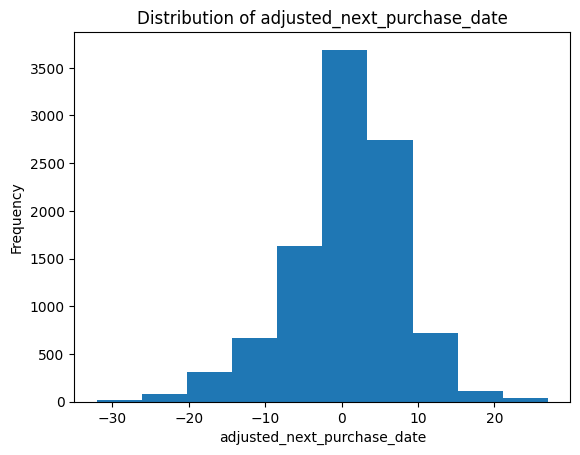

Number of values lower than 0 in adjusted_next_purchase_date: 4246


,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions,average_unit_per_transaction,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,adjusted_next_purchase_date,purchase_week_in_february
0,0,0,20664,88.052856,400,94.500000,6,1.000000,5.000000,0.722222,365.222222,0.666667,118.777778,6,4.0
1,1,0,28231,39.266312,55,33.000000,6,1.000000,4.210526,0.789474,434.868421,0.763158,69.868421,5,4.0
2,2,13,2690,63.502056,493,67.000000,17,1.176471,9.023622,0.779528,477.299213,0.921260,54.740157,4,4.0
3,3,15,1299,43.588779,64,42.333333,13,1.307692,6.526506,0.663855,481.528916,1.156627,89.350602,4,4.0
4,4,15,20968,39.564148,3824,36.333333,13,1.307692,4.000000,0.000000,444.000000,0.000000,144.000000,5,4.0


In [41]:
# Create a function to get the last row of each customer-cluster pair
def get_last_row(customer_id, cluster_id):
    group = filtered_transactions[(filtered_transactions['customer_id'] == customer_id) & (filtered_transactions['cluster_id'] == cluster_id)]
    return group.iloc[-1]['next_purchase_date']

# Apply the function to each row in the test_data
test_data['adjusted_next_purchase_date'] = test_data.apply(
    lambda row: 1 + ((timedelta(days=row['prediction']).days - (pd.Timestamp('2021-02-01') - get_last_row(row['customer_id'], row['cluster_id'])).days) // 7),
    axis=1
)


# Plot the adjusted_next_purchase_date column
test_data['adjusted_next_purchase_date'].plot(kind='hist', title='Distribution of adjusted_next_purchase_date')
plt.xlabel('adjusted_next_purchase_date')
plt.ylabel('Frequency')
plt.show()


negative_values_count = test_data[test_data['adjusted_next_purchase_date'] <= 0].shape[0]
print(f"Number of values lower than 0 in adjusted_next_purchase_date: {negative_values_count}")

test_data['purchase_week_in_february'] = test_data.apply(
    lambda row: 0 if row['adjusted_next_purchase_date'] <= -4 else 1 if row['adjusted_next_purchase_date'] <= 0 else row['adjusted_next_purchase_date'] if row['adjusted_next_purchase_date'] <= 4 else 4 if row['adjusted_next_purchase_date'] <= 6 else 0,
    axis=1
)

test_data.head()

In [42]:
test_data['purchase_week_in_february'] = test_data['purchase_week_in_february'].astype(int)

In [43]:
display(test_data)

,id,customer_id,product_id,prediction,cluster_id,average_repurchased_day,total_transactions,average_unit_per_transaction,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,adjusted_next_purchase_date,purchase_week_in_february
0,0,0,20664,88.052856,400,94.500000,6,1.000000,5.000000,0.722222,365.222222,0.666667,118.777778,6,4
1,1,0,28231,39.266312,55,33.000000,6,1.000000,4.210526,0.789474,434.868421,0.763158,69.868421,5,4
2,2,13,2690,63.502056,493,67.000000,17,1.176471,9.023622,0.779528,477.299213,0.921260,54.740157,4,4
3,3,15,1299,43.588779,64,42.333333,13,1.307692,6.526506,0.663855,481.528916,1.156627,89.350602,4,4
4,4,15,20968,39.564148,3824,36.333333,13,1.307692,4.000000,0.000000,444.000000,0.000000,144.000000,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,46118,20106,43.116207,163,42.250000,15,1.400000,4.000000,0.500000,491.000000,0.000000,66.000000,1,1
9996,9996,46124,19677,37.765060,5257,33.600000,18,1.000000,4.000000,0.500000,491.000000,3.000000,89.333333,5,4
9997,9997,46125,12878,109.011047,682,120.500000,3,1.000000,4.000000,0.400000,451.800000,0.000000,81.600000,16,0
9998,9998,46127,7963,31.145111,951,25.250000,6,1.500000,5.959184,0.816327,401.734694,0.918367,80.795918,-2,1


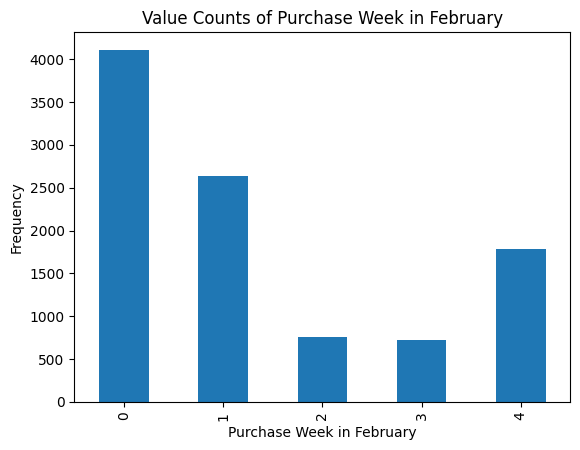

In [44]:
# Plot the value counts in the purchase_week_in_february column
test_data['purchase_week_in_february'].value_counts().sort_index().plot(kind='bar', title='Value Counts of Purchase Week in February')
plt.xlabel('Purchase Week in February')
plt.ylabel('Frequency')
plt.show()

In [45]:
# Sort the combined_df by id
result_df = test_data.sort_values(by='id')

# Drop columns other than id, customer_id, product_id, subboostmodel_prediction
result_df = result_df[['id', 'customer_id', 'product_id', 'purchase_week_in_february']]

# Rename the subboostmodel_prediction column to prediction
result_df = result_df.rename(columns={'purchase_week_in_february': 'prediction'})

result_df.head()

,id,customer_id,product_id,prediction
0,0,0,20664,4
1,1,0,28231,4
2,2,13,2690,4
3,3,15,1299,4
4,4,15,20968,4


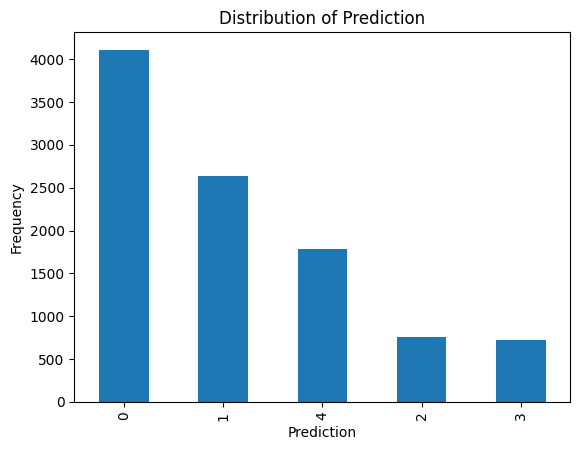

In [46]:
# Get the distribution of the prediction column
prediction_distribution = result_df['prediction'].value_counts()

# Plot the distribution
prediction_distribution.plot(kind='bar', title='Distribution of Prediction')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.show()

In [47]:
result_df.to_csv("result_df.csv", index=False)